In [1]:
import numpy as np
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_
import matplotlib.pyplot as plt
import gym
env=gym.make('CartPole-v0')
print("State space:", env.observation_space)
print("Action space:", env.action_space)

State space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Action space: Discrete(2)


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.12/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.12/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which 

In [5]:
class policyNetwork:
  def __init__(self,state_dim,action_dim):
    self.state_dim=state_dim
    self.action_dim=action_dim

    self.w1=np.random.randn(self.state_dim,4)*0.1
    self.b1=np.random.randn(1,4)

    self.w2=np.random.randn(4,action_dim)*0.1
    self.b2=np.random.randn(1,action_dim)

  def forward(self,state):
    if len(state.shape) == 1:
      state = state.reshape(1, -1)

    z1=state @ self.w1+self.b1
    a1=np.maximum(0,z1)

    z2=a1 @ self.w2+self.b2
    exp_z=np.exp(z2-np.max(z2, axis=1, keepdims=True))
    probs=exp_z/np.sum(exp_z, axis=1, keepdims=True)

    cache={
        'state':state,
        'z1':z1,
         'a1':a1,
         'z2':z2,
         'probs':probs[0]
    }

    return probs[0],cache

  def select_action(self,state):
    probs,cache=self.forward(state)
    action=np.random.choice(self.action_dim,p=probs)

    log_prob=np.log(probs[action]+1e-10)

    cache['action']=action
    cache['log_prob']=log_prob

    return action,log_prob,cache


#Gradient of log π(a|s) with respect to logits
#For softmax: ∇ log π(a|s) = e_a - π
#where e_a is one-hot vector for action a

  def compute_gradient(self,cache,advantage):
    state=cache['state']
    a1=cache['a1']
    probs=cache['probs']
    action=cache['action']

    one_hot = np.zeros(self.action_dim)
    one_hot[action] = 1

    dz2=probs.copy()
    dz2[action]-=1
    dz2=-dz2*advantage
    dz2 = dz2.reshape(1, -1)

    a1_flat = a1.flatten()

    #backprop
    dw2 = a1.T @ dz2
    db2=dz2

    da1=dz2 @ self.w2.T

    dz1 = da1.copy()
    dz1[cache['z1'] <= 0] = 0

    dw1 = state.T @ dz1
    db1 = dz1

    return {
            'dw1': dw1,
            'db1': db1,
            'dw2': dw2,
            'db2': db2
        }

  def update_parameters(self,gradients,learning_rate):
    self.w1 += learning_rate * gradients['dw1']
    self.b1 += learning_rate * gradients['db1']
    self.w2 += learning_rate * gradients['dw2']
    self.b2 += learning_rate * gradients['db2']









In [6]:
class REINFORCE:
  def __init__(self,env,learning_rate=0.01,gamma=0.99):
    self.env=env
    self.gamma=gamma
    self.learning_rate=learning_rate
    state_dim=env.observation_space.shape[0]
    action_dim=env.action_space.n
    self.baseline=0
    self.baseline_alpha=0.01

    self.policy=policyNetwork(state_dim,action_dim)

    self.episode_rewards=[]

  def compute_returns(self,rewards):
    #discounted rewards
    returns=[]
    G=0
    for r in reversed(rewards):
      G=r+self.gamma*G
      returns.insert(0,G)
    return np.array(returns)

  def run_episode(self):
    state=self.env.reset()
    states=[]
    actions=[]
    rewards=[]
    caches=[]

    done=False
    while not done:

      action,log_prob,cache=self.policy.select_action(state)
      next_state,reward,done,_=self.env.step(action)

      states.append(state)
      actions.append(action)
      rewards.append(reward)
      caches.append(cache)

      state=next_state

    total_reward=sum(rewards)

    return states, actions, rewards, caches, total_reward

  def train_episode(self):
    states,actions,rewards,caches,total_reward=self.run_episode()
    returns=self.compute_returns(rewards)
    baseline_adjusted = returns - self.baseline
    self.baseline = (1 - self.baseline_alpha) * self.baseline + \
                       self.baseline_alpha * returns.mean()

    #returns=(returns-returns.mean())/(returns.std()+1e-9)

    accumulated_grads={
        'dw1':np.zeros_like(self.policy.w1),
        'db1':np.zeros_like(self.policy.b1),
        'dw2':np.zeros_like(self.policy.w2),
        'db2':np.zeros_like(self.policy.b2)
    }

    for i in range(len(states)):
      Gt=returns[i]
      grads=self.policy.compute_gradient(caches[i],Gt)

      for key in accumulated_grads.keys():
        accumulated_grads[key]+=grads[key]

    self.policy.update_parameters(accumulated_grads,self.learning_rate)
    self.episode_rewards.append(total_reward)
    return total_reward

  def train(self,num_episodes):
    for episode in range(num_episodes):
      reward=self.train_episode()
      print(f"Episode {episode+1}/{num_episodes}, Reward: {reward}")


  def plot_training(self):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(self.episode_rewards, alpha=0.3, label='Episode Reward')

    window = 50
    if len(self.episode_rewards) >= window:
        moving_avg = np.convolve(self.episode_rewards,
                                     np.ones(window)/window, mode='valid')
        plt.plot(range(window-1, len(self.episode_rewards)),
                    moving_avg, 'r-', linewidth=2, label=f'{window}-Episode Avg')

    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Training Progress')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    final_rewards = self.episode_rewards[-100:]
    plt.hist(final_rewards, bins=20, edgecolor='black', alpha=0.7)
    plt.xlabel('Reward')
    plt.ylabel('Frequency')
    plt.title('Final 100 Episodes')
    plt.axvline(np.mean(final_rewards), color='red',
                   linestyle='--', linewidth=2,
                   label=f'Mean: {np.mean(final_rewards):.1f}')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()




Episode 1/1000, Reward: 36.0
Episode 2/1000, Reward: 53.0
Episode 3/1000, Reward: 12.0
Episode 4/1000, Reward: 14.0
Episode 5/1000, Reward: 18.0
Episode 6/1000, Reward: 18.0
Episode 7/1000, Reward: 25.0
Episode 8/1000, Reward: 32.0
Episode 9/1000, Reward: 31.0
Episode 10/1000, Reward: 65.0
Episode 11/1000, Reward: 35.0
Episode 12/1000, Reward: 25.0
Episode 13/1000, Reward: 17.0
Episode 14/1000, Reward: 13.0
Episode 15/1000, Reward: 18.0
Episode 16/1000, Reward: 19.0
Episode 17/1000, Reward: 20.0
Episode 18/1000, Reward: 24.0
Episode 19/1000, Reward: 23.0
Episode 20/1000, Reward: 24.0
Episode 21/1000, Reward: 11.0
Episode 22/1000, Reward: 34.0
Episode 23/1000, Reward: 29.0
Episode 24/1000, Reward: 40.0
Episode 25/1000, Reward: 16.0
Episode 26/1000, Reward: 22.0
Episode 27/1000, Reward: 32.0
Episode 28/1000, Reward: 12.0
Episode 29/1000, Reward: 20.0
Episode 30/1000, Reward: 20.0
Episode 31/1000, Reward: 30.0
Episode 32/1000, Reward: 55.0
Episode 33/1000, Reward: 21.0
Episode 34/1000, Re

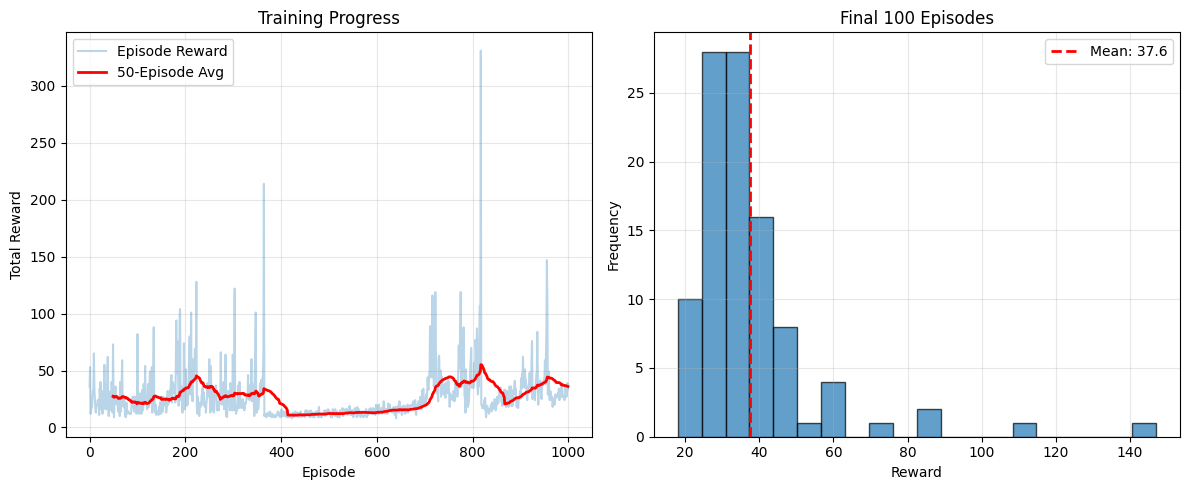

In [7]:

env=gym.make('CartPole-v1')

agent=REINFORCE(
    env=env,
    learning_rate=0.001,
    gamma=0.99
)

agent.train(num_episodes=1000)

agent.plot_training()

In [8]:
def test_agent(agent, num_episodes=5, render=False):
    test_rewards = []

    for episode in range(num_episodes):
        state = agent.env.reset()
        total_reward = 0
        done = False
        steps = 0

        while not done:
            if render:
                agent.env.render()
            probs, _ = agent.policy.forward(state)
            action = np.argmax(probs)

            state, reward, done, _ = agent.env.step(action)
            total_reward += reward
            steps += 1

        test_rewards.append(total_reward)
        print(f"Test Episode {episode + 1}: Reward = {total_reward:.0f}, Steps = {steps}")

    print(f"\nAverage Test Reward: {np.mean(test_rewards):.2f}")

    if render:
        agent.env.close()

test_agent(agent, num_episodes=5)

Test Episode 1: Reward = 37, Steps = 37
Test Episode 2: Reward = 30, Steps = 30
Test Episode 3: Reward = 28, Steps = 28
Test Episode 4: Reward = 33, Steps = 33
Test Episode 5: Reward = 31, Steps = 31

Average Test Reward: 31.80
